In [106]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_algorithms.utils import algorithm_globals
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import sklearn.metrics.cluster as cluster_metrics
import numpy as np
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.manifold import TSNE
from qiskit.circuit.library import RealAmplitudes
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
from sklearn.cluster import AgglomerativeClustering, KMeans
import torch
from torch import nn
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets
import math

# SEED

In [107]:
# Set all needed seed
import random
import numpy as np
import torch
import os

def set_seed(seed=42):
    """
    Set seed for reproducibility
    Args:
        seed (int): Seed value
    """
    # Python random
    random.seed(seed)
    
    # Numpy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # CUDA deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Qiskit determinism
    algorithm_globals.random_seed = seed
    
    # Environment variables
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## UTILS

In [108]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print("CUDA Available:  ", torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {color.BOLD} {str(device).upper()} {color.END} Acceleration")

CUDA Available:   True
Using  CUDA  Acceleration


In [109]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster_metrics.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def evaluate_clustering(X, pred_y, true_y):
    print(f"{'Silhouette:':15s}{silhouette_score(X, pred_y):2.3f}")
    print(f"{'Purity:':15s}{purity_score(true_y, pred_y):2.3f}")

def evaluate_clustering_table(X, pred_y, true_y):
    return silhouette_score(X, pred_y), purity_score(true_y, pred_y)

# DATASET IMPORT

In [110]:
INITIAL_TRAINING_SAMPLES = 400


MNIST_base_transform = transforms.Compose([
transforms.ToTensor()
])


MNIST_dataset_train = datasets.MNIST(root="quantum_metric_learning-master/data/dataset/MNIST", train=True, download=True, transform=MNIST_base_transform)
MNIST_dataset_test = datasets.MNIST(root="quantum_metric_learning-master/data/dataset/MNIST", train=False, download=True, transform=MNIST_base_transform)


if False:
    index01 = MNIST_dataset_train.train_labels <= 1
    MNIST_dataset_train.data = MNIST_dataset_train.data[index01]
    MNIST_dataset_train.targets = MNIST_dataset_train.targets[index01]

    index01_test = MNIST_dataset_test.train_labels <= 1
    MNIST_dataset_test.data = MNIST_dataset_test.data[index01_test]
    MNIST_dataset_test.targets = MNIST_dataset_test.targets[index01_test]




print(f"FULL DATASET INFO")
print(f"Image shape            : {MNIST_dataset_train.data.shape}")
print(f"Total training samples : {len(MNIST_dataset_train)}")
print(f"Total test     samples : {len(MNIST_dataset_test)}")
print("")

init_train_data, _, init_train_target, _ = train_test_split(
    range(len(MNIST_dataset_train)), 
    MNIST_dataset_train.targets,
    random_state=42,
    stratify=MNIST_dataset_train.targets,
    test_size=len(MNIST_dataset_train)- INITIAL_TRAINING_SAMPLES)


X = MNIST_dataset_train.data[init_train_data].numpy().astype("float32") / 255
y = MNIST_dataset_train.targets[init_train_data].numpy().astype("float32") 

print("TRAINING DATA INFO")
print(f"Image shape            : {X.shape}")
print(f"Total training samples : {len(X)}")
print("")


'''
init_test_data, _, init_test_target, _ = train_test_split(
    range(len(MNIST_dataset_test)), 
    MNIST_dataset_test.targets,
    random_state=42,
    stratify=MNIST_dataset_test.targets,
    test_size=len(MNIST_dataset_test)- INITIAL_TESTING_SAMPLES)
'''

X_test = MNIST_dataset_test.data.numpy().astype("float32") / 255
y_test = MNIST_dataset_test.targets.numpy().astype("float32")

print("TESTING DATA INFO")
print(f"Image shape            : {X_test.shape}")
print(f"Total training samples : {len(X_test)}")
print("")



FULL DATASET INFO
Image shape            : torch.Size([60000, 28, 28])
Total training samples : 60000
Total test     samples : 10000

TRAINING DATA INFO
Image shape            : (400, 28, 28)
Total training samples : 400

TESTING DATA INFO
Image shape            : (10000, 28, 28)
Total training samples : 10000



In [111]:
class MNIST_Distance_Dataset_Triplet_Loss(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.kers = np.ones((self.data.shape[0], self.data.shape[0]))
        self.output_transform = transforms.ToTensor()
        self.len = len(self.target)
        self.classes = {i:(np.where(self.target == i)[0], np.where(self.target != i)[0] ) for i in range(10)}


    def __getitem__(self, idx):
        return self.get_anchor(idx), self.get_positive(idx), self.get_negative(idx)
    
    def get_anchor(self, idx):
        return self.output_transform(self.data[idx])
    

    def get_positive(self, idx):
        i = np.random.choice(self.classes[self.target[idx]][0])
        return self.output_transform(self.data[i])
    
    def get_negative(self, idx):
        i = np.random.choice(self.classes[self.target[idx]][1])
        return self.output_transform(self.data[i])


    def get_order(self):
        return self.target.argsort()


    def ordered_pairwise(self):
        return self.kers[:,self.get_order()][self.get_order(),:]


    def get_flatten(self):
        return self.data.reshape((self.data.shape[0], self.data.shape[1]**2))


    def __len__(self):
        return self.len

300
100


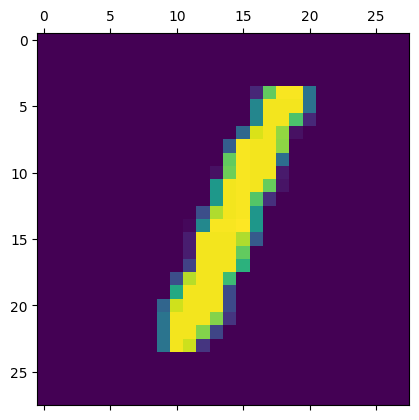

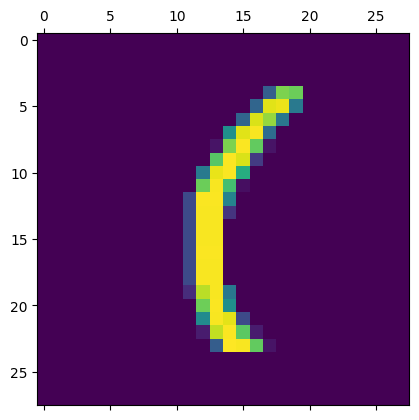

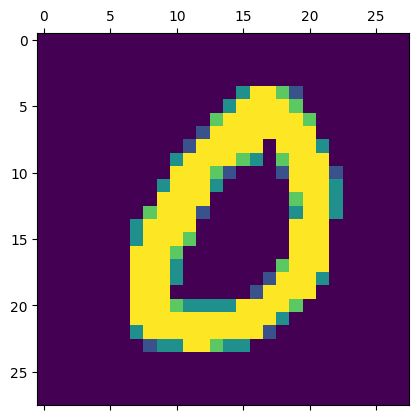

In [112]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
t = MNIST_Distance_Dataset_Triplet_Loss(X_train, y_train)
v = MNIST_Distance_Dataset_Triplet_Loss(X_val, y_val)
#stampa lunghezza del dataset

print(len(t))
print(len(v))

anchor, pos, neg = t[0]


plt.matshow(anchor.squeeze(0))
plt.matshow(pos.squeeze(0))
plt.matshow(neg.squeeze(0))



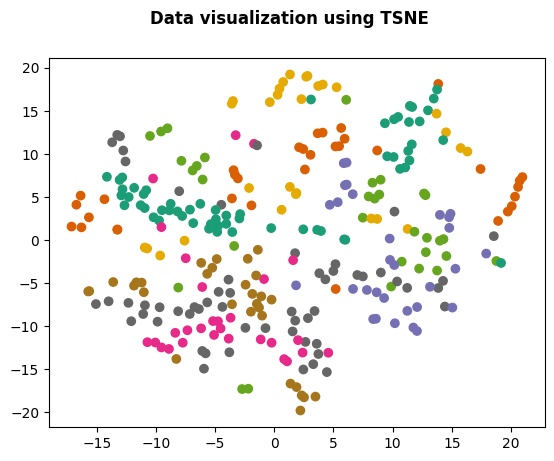

In [113]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t.get_flatten(), t.target)

fig, ax = plt.subplots()
fig.suptitle("Data visualization using TSNE", weight="bold")
ax.scatter(vis_x[:,0], vis_x[:,1], c=t.target, cmap='Dark2')

# ENCODERS


### Amplitude encoding

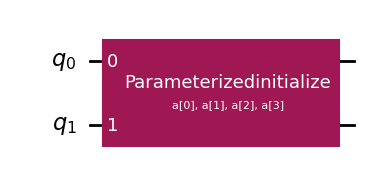

In [114]:
'''
Amplitude encoding, richiede nlog2 features
'''
def amplitude_encoding(n_features, param_name):
  qc = RawFeatureVector(n_features)
  qc = qc.assign_parameters(ParameterVector(param_name, n_features))
  qc.name = f"Amplitude Encoding {param_name}"
  return qc

amplitude_encoding(4, "a").draw(output="mpl")

### YZ angles encoding

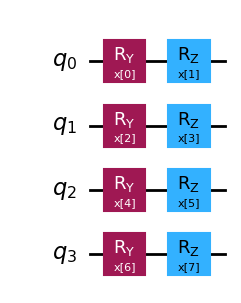

In [115]:
def yz_angles_encoding(n_features, param_name=None, params=None):
  """
  Encoding YZ con rotazioni RY e RZ.
  
  Args:
      n_features: numero di feature
      param_name: nome dei parametri (crea un nuovo ParameterVector)
      params: ParameterVector esistente da riutilizzare
  
  Nota: Specificare uno solo tra param_name e params
  """
  if params is None:
      if param_name is None:
          raise ValueError("Specificare param_name o params")
      params = ParameterVector(param_name, n_features)
  
  n_qubit = math.ceil(n_features / 2)
  qc = QuantumCircuit(n_qubit, name=f"Angles Encoding")
  gates = [qc.ry, qc.rz]

  for i in range(n_qubit):
    for gate_i in range(2):
      pindex = i*2 + gate_i
      if pindex < n_features:
        gates[gate_i](params[pindex], i)

  return qc

yz_angles_encoding(8, param_name="x").draw(output="mpl")

### Pooling layer

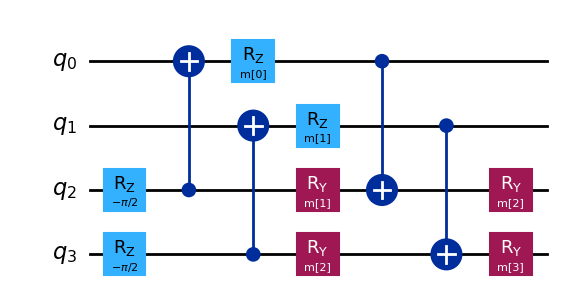

In [116]:
def pooling_layer(in_lane, param_prefix="pool"):
  qc = QuantumCircuit(in_lane, name="Pooling Layer")
  params = ParameterVector(param_prefix, length=in_lane //2 *3)

  for i in range(in_lane//2):
    current = i
    aux = i+ in_lane//2

    base_param =  current*(in_lane//2 -1)

    qc.rz(-np.pi/2, aux)
    qc.cx(aux, current)
    qc.rz(params[base_param + 0], current)
    qc.ry(params[base_param + 1], aux)
    qc.cx(current, aux)
    qc.ry(params[base_param + 2], aux)

  return qc

pooling_layer(4, param_prefix="m").draw(output="mpl")

# MODIFICHE ENCODING


### HRyRx encoding

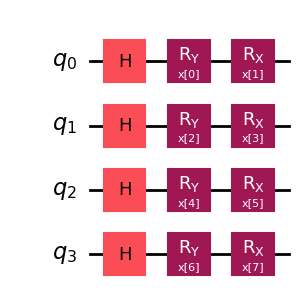

In [117]:
#Modifiche PROF
def hRyRx_encoding(n_features):
  # qubits
  n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  # feature extracted from neural network
  n_feature = n_features
  feature_map = QuantumCircuit(n_qubits)
  input_params = ParameterVector(name='x', length=n_feature)
  idx = 0
  for i in range(n_qubits):
      feature_map.h(i)
      feature_map.ry(input_params[idx], i)
      feature_map.rx(input_params[idx+1], i)
      idx +=2

  return feature_map

hRyRx_encoding(8).draw(output="mpl")


### HRyRz encoding

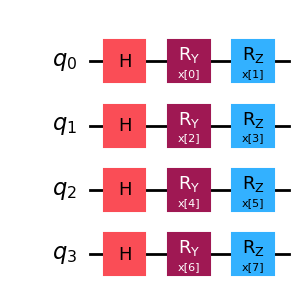

In [118]:
def hRyRz_encoding(n_features):
  # qubits
  n_qubits = math.floor(n_features /2) + (1 if (n_features % 2) != 0 else 0)
  # feature extracted from neural network
  n_feature = n_features
  feature_map = QuantumCircuit(n_qubits)
  input_params = ParameterVector(name='x', length=n_feature)
  idx = 0
  for i in range(n_qubits):
      feature_map.h(i)
      feature_map.ry(input_params[idx], i)
      feature_map.rz(input_params[idx+1], i)
      idx +=2
  return feature_map

hRyRz_encoding(8).draw(output="mpl")

### X angles encoding

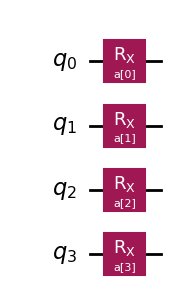

In [119]:
def x_angles_encoding(n_features, param_name):
  params = ParameterVector(param_name, n_features)
  n_qubit = n_features
  qc = QuantumCircuit(n_qubit, name=f"Angles Encoding {param_name}")
  

  for i in range(n_qubit):
    qc.rx(params[i], i)

  return qc

x_angles_encoding(4, "a").draw(output="mpl")

# ANSATZ

### MPS


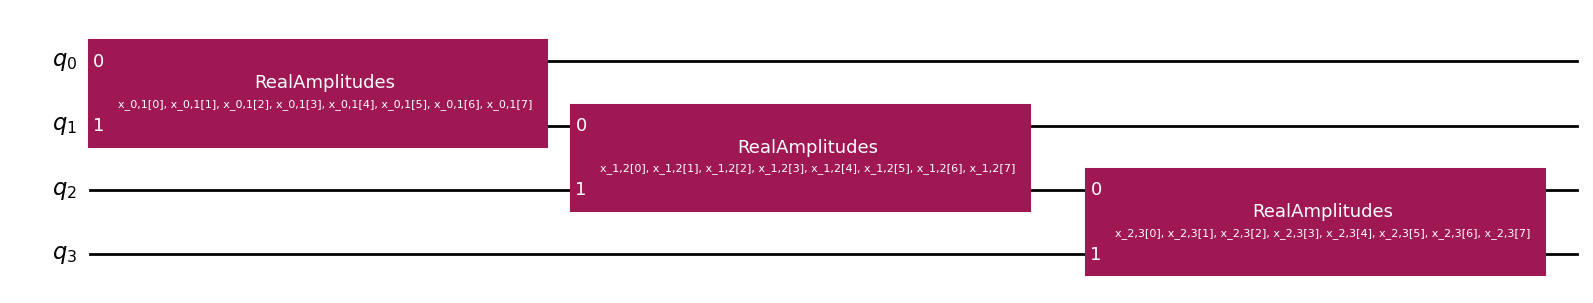

In [126]:
def MPS(num_qubits,parameter_prefix="x", **kwargs):
    """
    Constructs a Matrix Product State (MPS) quantum circuit.

    Args:
        num_qubits (int): The number of qubits in the circuit.
        **kwargs: Additional keyword arguments to be passed to the 
        RealAmplitudes.

    Returns:
        QuantumCircuit: The constructed MPS quantum circuit.
        
    """
    qc = QuantumCircuit(num_qubits)
    qubits = range(num_qubits)
    for i, j in zip(qubits[:-1], qubits[1:]):
        block = RealAmplitudes(2, parameter_prefix=f"{parameter_prefix}_{i},{j}", **kwargs)
        qc.compose(block, [i, j], inplace=True)
        # if i < num_qubits - 2:
        #     qc.barrier()
    return qc

MPS(4).draw('mpl')

# CIRCUITS

### Definizione del circuito originale ( Con RealAmplitudes + Pooling)

Decommentare l'encoding necessario per poter effettuare gli esperimenti opportuni


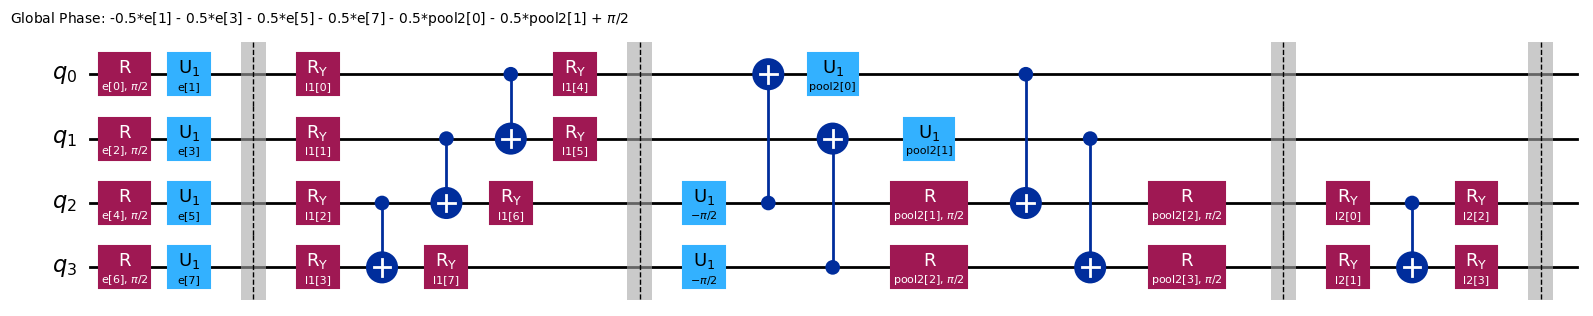

In [127]:
encoding = yz_angles_encoding(8, param_name="e")
#encoding = hRyRx_encoding(8)
#encoding= hRyRz_encoding(8)
#encoding = RyRx_encoding(8)





ansatz = QuantumCircuit(4)
ansatz.barrier()
############################2#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=4, reps=1, name="Layer1", parameter_prefix="l1"))
ansatz.barrier()
############################3#######################
ansatz = ansatz.compose(pooling_layer(4, "pool2"))
ansatz.barrier()
############################4#######################
ansatz = ansatz.compose(RealAmplitudes(num_qubits=2, reps=1, name="Layer2",parameter_prefix="l2"), qubits=[2,3])
ansatz.barrier()

ansatz.decompose().draw(output="mpl")


qnn = QuantumCircuit(4).compose(encoding).compose(ansatz)

display(qnn.decompose().draw("mpl"))



### Circuito con TN (solo MPS)

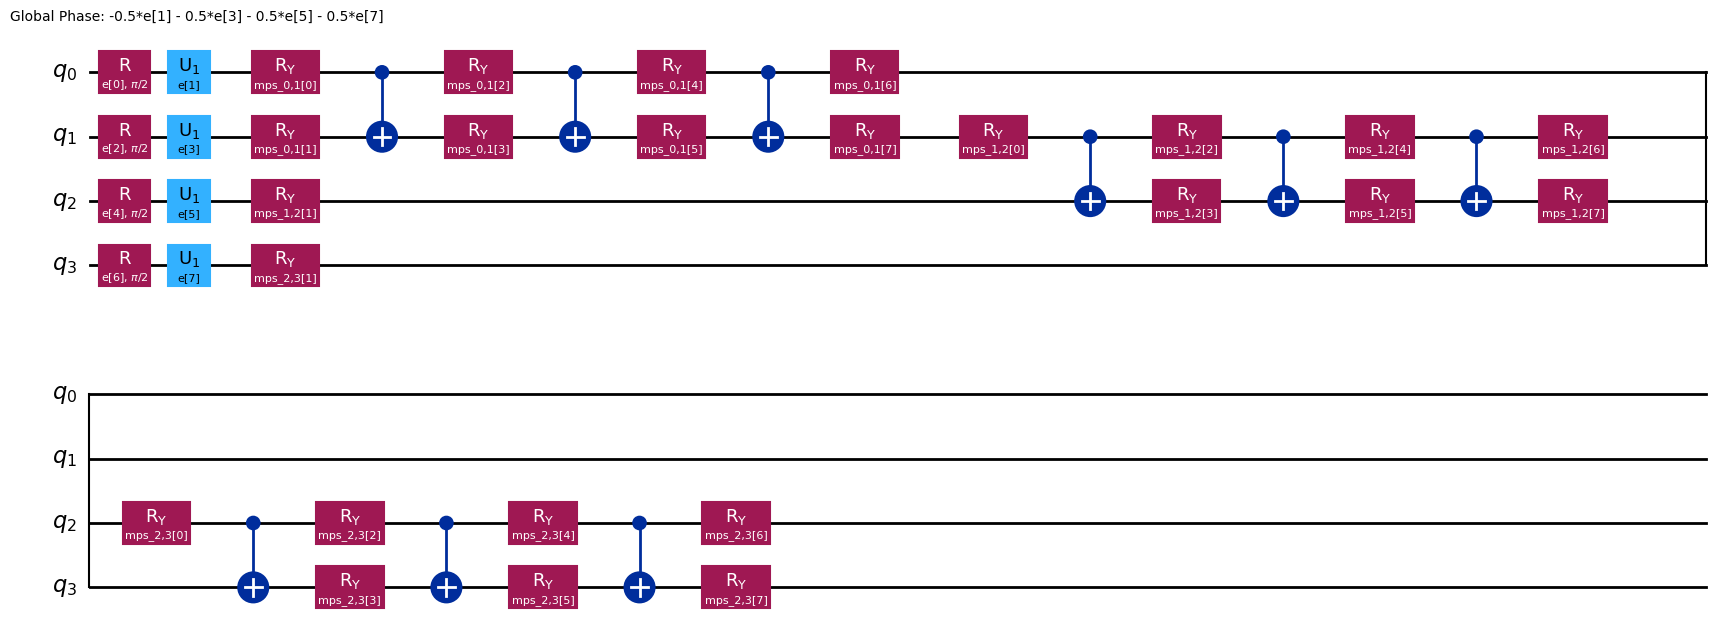

In [128]:
encoding = yz_angles_encoding(8, param_name="e")


qnn = QuantumCircuit(4).compose(encoding)

# Aggiunta dell'MPS al circuito
ansatz = MPS(num_qubits=4, parameter_prefix="mps")
qnn = qnn.compose(ansatz)

# Visualizzazione del circuito
display(qnn.decompose().draw("mpl"))

In [129]:
print("Encoding parameters:", len(encoding.parameters))
print("Ansatz parameters:", len(ansatz.parameters))
print("Total parameters in circuit:", len(qnn.parameters))

Encoding parameters: 8
Ansatz parameters: 24
Total parameters in circuit: 32


# HYBRID NETWORKS



### 8-features per image

In [132]:
from qiskit.primitives import Sampler
def parity(x):
    return f"{bin(x)}".count("1")

# SCELTA DEL CIRCUITO QUANTISTICO
# Opzione 1: Circuito con MPS standard
# qnn_circuit_8 = qnn
# input_ps_8 = encoding.parameters
# weight_ps_8 = ansatz.parameters

# Opzione 2: Circuito con MPS reuploading
qnn_circuit_8 = qnn_std_reupload
# Separa i parametri: i primi 8 sono input, il resto sono weight dall'ansatz MPS
input_ps_8 = list(qnn_circuit_8.parameters)[:8]
weight_ps_8 = list(qnn_circuit_8.parameters)[8:]

qmodel_8 = SamplerQNN(
    circuit=qnn_circuit_8,
    input_params=input_ps_8,
    weight_params=weight_ps_8,
    input_gradients=True
)


class HybridRegressorConvNet8Features(nn.Module):
    def __init__(self, qm1):
        super().__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5)),
            nn.ReLU()
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        
        self.reduction = nn.Sequential(
            nn.Linear(in_features=576, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=8)
        )
     
        self.final = nn.Sequential(
            nn.Linear(in_features=16, out_features=16),

        )

        self.q1 = TorchConnector(qm1)
    

    def forward(self, x):

        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)

        x = self.flatten(x)

        x = self.reduction(x)

        #Per encoding con HRyRz
        #x = x * (math.pi / 2)
        #x= self.q1(x)
        
        x = self.q1(x) * 100

        x = self.final(x)

        return x
    

distance_model_8 = HybridRegressorConvNet8Features(qmodel_8)
distance_model_8 = distance_model_8.to(device)
summary(distance_model_8, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          25,632
         MaxPool2d-4           [-1, 32, 10, 10]               0
              ReLU-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
         MaxPool2d-7             [-1, 64, 3, 3]               0
              ReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 120]          69,240
             ReLU-11                  [-1, 120]               0
           Linear-12                    [-1, 8]             968
   TorchConnector-13                   [-1, 16]              24
           Linear-14                   

# TRAIN

### Training setup

In [134]:
model_to_train = qmodel_8
distance_model = HybridRegressorConvNet8Features(model_to_train)
training_dataloader = DataLoader(t, batch_size=8, shuffle=True)
val_data_loader = DataLoader(v, batch_size=8, shuffle=True)
distance_model = distance_model.to(device)
optimizer = torch.optim.SGD(distance_model.parameters(), lr=1e-2)
loss = torch.nn.TripletMarginLoss(margin=2)
epochs = 100

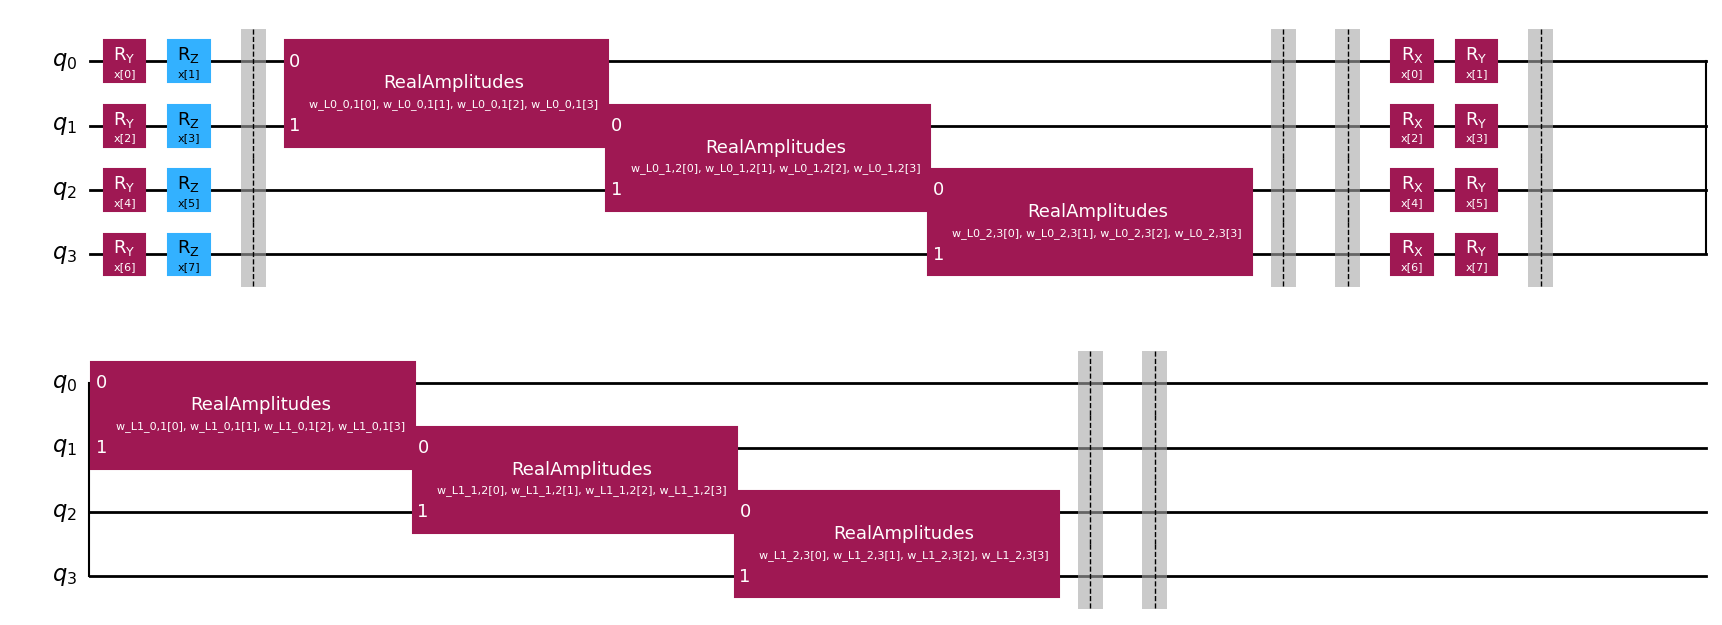

In [135]:
model_to_train.circuit.draw(output="mpl")

### Training loop

In [136]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, validation_step=False, print_at=1, seed= 42):

    
    set_seed(seed)
    for epoch in range(epochs):
        set_seed(seed + epoch)
        
        prnt = (epoch % print_at) != 0 if epoch!=(epochs-1) else False


        if not(prnt):
            print(f"{color.BOLD}Epoch {color.END}{epoch+1}")

        ### --> Training Phase

        model.train()

        train_loss = 0.0
        train_samples = 0

        

        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()


            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)


            e_A = model(anchor)
            e_P = model(positive)
            e_N = model(negative)


            

            loss = criterion(e_A, e_P, e_N)

            loss.backward()
            optimizer.step()

            train_loss += loss 
            train_samples += positive.size(0)


        train_loss /= len(train_data_loader)
        
        if not(prnt):
            print(f"TRAINING   -> Loss: {train_loss:2.6f}")
            print("")    

### Training loop with early stopping


In [137]:
def train(model, epochs, optimizer, criterion, train_data_loader, val_data_loader, device, 
          validation_step=False, print_at=1, early_stopping_patience=3, 
          min_delta=0.001, restore_best_weights=True, seed=42):
    
    set_seed(seed)
    best_loss = float('inf')
    no_improvement_count = 0
    best_model_state = None

    for epoch in range(epochs):
        
        set_seed(seed + epoch)
        prnt = (epoch % print_at) != 0 if epoch != (epochs-1) else False

        # Inizializza early_stopping_triggered all'inizio di ogni epoch
        early_stopping_triggered = False

        if not prnt:
            print(f"{color.BOLD}Epoch {color.END}{epoch+1}")

        ### --> Training Phase
        model.train()
        train_loss = 0.0
        train_samples = 0

        for anchor, positive, negative in tqdm(train_data_loader, disable=prnt):
            optimizer.zero_grad()
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            e_A = model(anchor)
            e_P = model(positive)
            e_N = model(negative)

            loss = criterion(e_A, e_P, e_N)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_samples += positive.size(0)

        train_loss /= len(train_data_loader)
        
        ### --> Validation Phase (solo se richiesto)
        val_loss = 0.0
        if validation_step and not prnt:
            model.eval()
            with torch.no_grad():
                for anchor, positive, negative in val_data_loader:
                    anchor = anchor.to(device)
                    positive = positive.to(device)
                    negative = negative.to(device)

                    e_A = model(anchor)
                    e_P = model(positive)
                    e_N = model(negative)

                    loss = criterion(e_A, e_P, e_N)
                    val_loss += loss.item()

                val_loss /= len(val_data_loader)

        ### --> Early Stopping Logic
        if validation_step and not prnt:
            # Controlla miglioramento
            if (best_loss - val_loss) > min_delta:
                best_epoch = epoch
                best_loss = val_loss
                no_improvement_count = 0
                # Salva lo stato del modello migliore
                if restore_best_weights:
                    print("Best epoch: ", best_epoch)
                    best_model_state = model.state_dict().copy()
            else:
                no_improvement_count += 1
                if no_improvement_count >= early_stopping_patience:
                    print(f"\n{color.RED}Early stopping at epoch {epoch+1}{color.END}")
                    early_stopping_triggered = True

        ### --> Stampa risultati
        if not prnt:
            log_str = f"TRAINING   -> Loss: {train_loss:2.6f}"
            if validation_step:
                log_str += f" | VALIDATION -> Loss: {val_loss:2.6f}"
            print(log_str)
            print("")

        ### --> Interrompi il training se early stopping
        if early_stopping_triggered:
            break

    ### --> Ripristina i migliori pesi se richiesto
    if restore_best_weights and best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"{color.GREEN}Restored best model weights{color.END}")

    return model

### Train execution

In [ ]:
#Train senza Early Stopping

train(
    model=distance_model,
    epochs=100,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    val_data_loader=None,
    validation_step=False,
    device=device,
    print_at=1,
    seed=42
)


#Train con Early Stopping
'''
distance_model = train(
    distance_model,
    epochs=100,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    val_data_loader=val_data_loader,
    device=device,
    validation_step=True,
    early_stopping_patience=4,
    min_delta=0.005,
    seed=42
)
'''

#save the model
with open(r"models/triplet_loss/QuantumTripletLossMNIST_TTN.pt", "wb") as f:
    torch.save(distance_model.state_dict(), f)

Epoch 1


100%|██████████| 38/38 [03:31<00:00,  5.57s/it]


TRAINING   -> Loss: 1.416110

Epoch 2


100%|██████████| 38/38 [03:41<00:00,  5.82s/it]


TRAINING   -> Loss: 0.968684

Epoch 3


100%|██████████| 38/38 [03:44<00:00,  5.91s/it]


TRAINING   -> Loss: 0.810713

Epoch 4


100%|██████████| 38/38 [04:01<00:00,  6.34s/it]


TRAINING   -> Loss: 0.553691

Epoch 5


100%|██████████| 38/38 [03:45<00:00,  5.94s/it]


TRAINING   -> Loss: 0.668211

Epoch 6


100%|██████████| 38/38 [03:42<00:00,  5.85s/it]


TRAINING   -> Loss: 0.440300

Epoch 7


100%|██████████| 38/38 [03:43<00:00,  5.87s/it]


TRAINING   -> Loss: 0.397081

Epoch 8


100%|██████████| 38/38 [03:41<00:00,  5.84s/it]


TRAINING   -> Loss: 0.294940

Epoch 9


100%|██████████| 38/38 [03:44<00:00,  5.92s/it]


TRAINING   -> Loss: 0.247427

Epoch 10


100%|██████████| 38/38 [03:42<00:00,  5.85s/it]


TRAINING   -> Loss: 0.266133

Epoch 11


100%|██████████| 38/38 [03:42<00:00,  5.86s/it]


TRAINING   -> Loss: 0.346756

Epoch 12


100%|██████████| 38/38 [03:40<00:00,  5.81s/it]


TRAINING   -> Loss: 0.239552

Epoch 13


100%|██████████| 38/38 [03:36<00:00,  5.69s/it]


TRAINING   -> Loss: 0.193555

Epoch 14


100%|██████████| 38/38 [03:33<00:00,  5.63s/it]


TRAINING   -> Loss: 0.179288

Epoch 15


100%|██████████| 38/38 [03:32<00:00,  5.60s/it]


TRAINING   -> Loss: 0.185100

Epoch 16


100%|██████████| 38/38 [03:31<00:00,  5.56s/it]


TRAINING   -> Loss: 0.193602

Epoch 17


100%|██████████| 38/38 [03:31<00:00,  5.56s/it]


TRAINING   -> Loss: 0.197708

Epoch 18


100%|██████████| 38/38 [03:34<00:00,  5.65s/it]


TRAINING   -> Loss: 0.234650

Epoch 19


100%|██████████| 38/38 [03:31<00:00,  5.56s/it]


TRAINING   -> Loss: 0.116511

Epoch 20


100%|██████████| 38/38 [03:32<00:00,  5.60s/it]


TRAINING   -> Loss: 0.122142

Epoch 21


100%|██████████| 38/38 [03:36<00:00,  5.70s/it]


TRAINING   -> Loss: 0.103148

Epoch 22


100%|██████████| 38/38 [04:21<00:00,  6.89s/it]


TRAINING   -> Loss: 0.072387

Epoch 23


100%|██████████| 38/38 [03:46<00:00,  5.96s/it]


TRAINING   -> Loss: 0.097547

Epoch 24


100%|██████████| 38/38 [03:33<00:00,  5.63s/it]


TRAINING   -> Loss: 0.115724

Epoch 25


100%|██████████| 38/38 [03:33<00:00,  5.63s/it]


TRAINING   -> Loss: 0.102047

Epoch 26


100%|██████████| 38/38 [03:33<00:00,  5.62s/it]


TRAINING   -> Loss: 0.093624

Epoch 27


100%|██████████| 38/38 [03:33<00:00,  5.61s/it]


TRAINING   -> Loss: 0.099044

Epoch 28


100%|██████████| 38/38 [03:34<00:00,  5.64s/it]


TRAINING   -> Loss: 0.110776

Epoch 29


100%|██████████| 38/38 [03:34<00:00,  5.65s/it]


TRAINING   -> Loss: 0.076910

Epoch 30


100%|██████████| 38/38 [03:36<00:00,  5.70s/it]


TRAINING   -> Loss: 0.048720

Epoch 31


100%|██████████| 38/38 [03:34<00:00,  5.65s/it]


TRAINING   -> Loss: 0.064653

Epoch 32


100%|██████████| 38/38 [03:39<00:00,  5.77s/it]


TRAINING   -> Loss: 0.096125

Epoch 33


100%|██████████| 38/38 [03:44<00:00,  5.91s/it]


TRAINING   -> Loss: 0.057044

Epoch 34


100%|██████████| 38/38 [03:40<00:00,  5.80s/it]


TRAINING   -> Loss: 0.039944

Epoch 35


100%|██████████| 38/38 [03:34<00:00,  5.64s/it]


TRAINING   -> Loss: 0.059835

Epoch 36


100%|██████████| 38/38 [03:31<00:00,  5.57s/it]


TRAINING   -> Loss: 0.051812

Epoch 37


100%|██████████| 38/38 [03:31<00:00,  5.57s/it]


TRAINING   -> Loss: 0.088351

Epoch 38


100%|██████████| 38/38 [03:39<00:00,  5.78s/it]


TRAINING   -> Loss: 0.019391

Epoch 39


100%|██████████| 38/38 [03:44<00:00,  5.90s/it]


TRAINING   -> Loss: 0.059405

Epoch 40


100%|██████████| 38/38 [03:30<00:00,  5.53s/it]


TRAINING   -> Loss: 0.053841

Epoch 41


100%|██████████| 38/38 [03:31<00:00,  5.57s/it]


TRAINING   -> Loss: 0.048679

Epoch 42


100%|██████████| 38/38 [03:33<00:00,  5.61s/it]


TRAINING   -> Loss: 0.068849

Epoch 43


100%|██████████| 38/38 [03:32<00:00,  5.59s/it]


TRAINING   -> Loss: 0.017508

Epoch 44


100%|██████████| 38/38 [03:34<00:00,  5.66s/it]


TRAINING   -> Loss: 0.030953

Epoch 45


100%|██████████| 38/38 [03:34<00:00,  5.64s/it]


TRAINING   -> Loss: 0.048110

Epoch 46


100%|██████████| 38/38 [03:33<00:00,  5.63s/it]


TRAINING   -> Loss: 0.000000

Epoch 47


100%|██████████| 38/38 [03:47<00:00,  5.99s/it]


TRAINING   -> Loss: 0.012761

Epoch 48


100%|██████████| 38/38 [03:33<00:00,  5.63s/it]


TRAINING   -> Loss: 0.017706

Epoch 49


100%|██████████| 38/38 [03:29<00:00,  5.52s/it]


TRAINING   -> Loss: 0.020497

Epoch 50


100%|██████████| 38/38 [03:28<00:00,  5.49s/it]


TRAINING   -> Loss: 0.021476

Epoch 51


100%|██████████| 38/38 [03:36<00:00,  5.69s/it]


TRAINING   -> Loss: 0.052975

Epoch 52


100%|██████████| 38/38 [03:52<00:00,  6.11s/it]


TRAINING   -> Loss: 0.055416

Epoch 53


100%|██████████| 38/38 [03:36<00:00,  5.70s/it]


TRAINING   -> Loss: 0.034730

Epoch 54


100%|██████████| 38/38 [03:35<00:00,  5.68s/it]


TRAINING   -> Loss: 0.013332

Epoch 55


100%|██████████| 38/38 [03:38<00:00,  5.75s/it]


TRAINING   -> Loss: 0.054060

Epoch 56


100%|██████████| 38/38 [03:35<00:00,  5.68s/it]


TRAINING   -> Loss: 0.043326

Epoch 57


100%|██████████| 38/38 [03:33<00:00,  5.61s/it]


TRAINING   -> Loss: 0.183304

Epoch 58


100%|██████████| 38/38 [03:32<00:00,  5.60s/it]


TRAINING   -> Loss: 0.010650

Epoch 59


100%|██████████| 38/38 [03:32<00:00,  5.58s/it]


TRAINING   -> Loss: 0.017493

Epoch 60


100%|██████████| 38/38 [03:33<00:00,  5.61s/it]


TRAINING   -> Loss: 0.007349

Epoch 61


100%|██████████| 38/38 [03:32<00:00,  5.60s/it]


TRAINING   -> Loss: 0.018188

Epoch 62


100%|██████████| 38/38 [03:35<00:00,  5.67s/it]


TRAINING   -> Loss: 0.002103

Epoch 63


100%|██████████| 38/38 [03:35<00:00,  5.67s/it]


TRAINING   -> Loss: 0.000000

Epoch 64


100%|██████████| 38/38 [03:31<00:00,  5.57s/it]


TRAINING   -> Loss: 0.034909

Epoch 65


100%|██████████| 38/38 [03:30<00:00,  5.54s/it]


TRAINING   -> Loss: 0.003020

Epoch 66


100%|██████████| 38/38 [03:36<00:00,  5.69s/it]


TRAINING   -> Loss: 0.002704

Epoch 67


100%|██████████| 38/38 [03:31<00:00,  5.55s/it]


TRAINING   -> Loss: 0.006584

Epoch 68


100%|██████████| 38/38 [03:30<00:00,  5.55s/it]


TRAINING   -> Loss: 0.000949

Epoch 69


100%|██████████| 38/38 [03:31<00:00,  5.56s/it]


TRAINING   -> Loss: 0.008606

Epoch 70


100%|██████████| 38/38 [03:29<00:00,  5.52s/it]


TRAINING   -> Loss: 0.012557

Epoch 71


100%|██████████| 38/38 [03:31<00:00,  5.56s/it]


TRAINING   -> Loss: 0.006886

Epoch 72


100%|██████████| 38/38 [03:30<00:00,  5.53s/it]


TRAINING   -> Loss: 0.000000

Epoch 73


100%|██████████| 38/38 [03:31<00:00,  5.56s/it]


TRAINING   -> Loss: 0.006811

Epoch 74


100%|██████████| 38/38 [03:31<00:00,  5.57s/it]


TRAINING   -> Loss: 0.000000

Epoch 75


100%|██████████| 38/38 [03:30<00:00,  5.54s/it]


TRAINING   -> Loss: 0.035579

Epoch 76


100%|██████████| 38/38 [03:30<00:00,  5.54s/it]


TRAINING   -> Loss: 0.030177

Epoch 77


100%|██████████| 38/38 [03:30<00:00,  5.55s/it]


TRAINING   -> Loss: 0.035400

Epoch 78


100%|██████████| 38/38 [03:31<00:00,  5.57s/it]


TRAINING   -> Loss: 0.035604

Epoch 79


100%|██████████| 38/38 [03:30<00:00,  5.54s/it]


TRAINING   -> Loss: 0.038572

Epoch 80


100%|██████████| 38/38 [03:32<00:00,  5.60s/it]


TRAINING   -> Loss: 0.022947

Epoch 81


100%|██████████| 38/38 [03:31<00:00,  5.57s/it]


TRAINING   -> Loss: 0.000000

Epoch 82


100%|██████████| 38/38 [03:31<00:00,  5.56s/it]


TRAINING   -> Loss: 0.000687

Epoch 83


100%|██████████| 38/38 [03:31<00:00,  5.56s/it]


TRAINING   -> Loss: 0.000000

Epoch 84


100%|██████████| 38/38 [03:32<00:00,  5.59s/it]


TRAINING   -> Loss: 0.000000

Epoch 85


100%|██████████| 38/38 [03:31<00:00,  5.56s/it]


TRAINING   -> Loss: 0.009040

Epoch 86


100%|██████████| 38/38 [03:32<00:00,  5.58s/it]


TRAINING   -> Loss: 0.004604

Epoch 87


100%|██████████| 38/38 [03:30<00:00,  5.55s/it]


TRAINING   -> Loss: 0.004642

Epoch 88


100%|██████████| 38/38 [03:33<00:00,  5.62s/it]


TRAINING   -> Loss: 0.027188

Epoch 89


100%|██████████| 38/38 [03:30<00:00,  5.55s/it]


TRAINING   -> Loss: 0.017503

Epoch 90


100%|██████████| 38/38 [03:34<00:00,  5.64s/it]


TRAINING   -> Loss: 0.014246

Epoch 91


100%|██████████| 38/38 [03:31<00:00,  5.57s/it]


TRAINING   -> Loss: 0.043958

Epoch 92


100%|██████████| 38/38 [03:38<00:00,  5.75s/it]


TRAINING   -> Loss: 0.003903

Epoch 93


 45%|████▍     | 17/38 [01:39<02:02,  5.82s/it]

In [ ]:
#save the model
with open(r"models/triplet_loss/QuantumTripletLossMNIST_TTN.pt", "wb") as f:
    torch.save(distance_model.state_dict(), f)

# EVALUATION

In [ ]:
with open(r"models/triplet_loss/QuantumTripletLossMNIST_TTN.pt", "rb") as f:
    distance_model.load_state_dict(torch.load(f))
distance_model

In [ ]:
training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

with torch.no_grad():
    distance_model.eval()
    embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(training_dataloader):
        anchor = anchor.to(device)
        embedding_data = np.concatenate((embedding_data,distance_model(anchor).to(device).squeeze(0).numpy()), axis=0)

In [ ]:
#confronto tra la distanza dei dati originali e la distanza dei dati embending ottenuiti tramite il modello ibrido
baseline_distance = metrics.pairwise_distances(t.get_flatten())
learned_distance = metrics.pairwise_distances(embedding_data)

In [ ]:
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(learned_distance)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

In [ ]:
quantum_clustering = KMeans(n_clusters=10,  init='k-means++', n_init=10,random_state=42)
quantum_prediction = quantum_clustering.fit_predict(embedding_data)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

In [ ]:
training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

with torch.no_grad():
    distance_model.eval()
    clustering_data = np.empty((0,8))
    for anchor, _,_ in tqdm(training_dataloader):
        x = anchor.to(device)
        x = distance_model.conv_1(x)
        x = distance_model.conv_2(x)
        x = distance_model.conv_3(x)
        x = distance_model.flatten(x)
        x = distance_model.reduction(x)
        clustering_data = np.concatenate((clustering_data,x.to(device).squeeze(0).numpy()), axis=0)

clustering_data.shape

In [ ]:
from qiskit import ClassicalRegister
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit.visualization import plot_histogram

#quantum_w è un insieme di pesi ottenuti da distance_model.q1. Viene trasformato in un array NumPy e usato nei parametri del circuito.
#qemb_circuit è il circuito quantistico associato alla rete neurale quantistica.
quantum_w = distance_model.q1.weight.detach().to(device).numpy()
qemb_circuit = distance_model.q1.neural_network.circuit

def quantum_embedding_distance(x,y):
    '''
    base: Un registro quantistico di 8 qubit per rappresentare i dati.
    ancilla: Un singolo qubit ausiliario necessario per lo SWAP test.
    classical: Un registro classico per immagazzinare il risultato della misura.
    swap_circuit: Il circuito quantistico che eseguirà il test.
    '''
    base = QuantumRegister(8, "data")
    ancilla = QuantumRegister(1, 'ancilla')
    classical = ClassicalRegister(1, 'output')
    swap_circuit = QuantumCircuit(base, ancilla, classical)

    '''
    w1 e w2 sono le versioni estese dei vettori x e y, a cui vengono aggiunti i pesi quantum_w.
    q1 e q2 sono i circuiti parametrizzati con w1 e w2, che rappresentano gli stati quantistici degli embedding.
    '''
    w1 = np.append(x, quantum_w)
    w2 = np.append(y, quantum_w)

    q1 = qemb_circuit.assign_parameters(w1)
    q2 = qemb_circuit.assign_parameters(w2)

    '''
    q1 viene caricato nei primi 4 qubit del registro base.
    q2 viene caricato nei secondi 4 qubit del registro base.
    A questo punto, il circuito ha due stati quantistici distinti |ψ1⟩ e |ψ2⟩ caricati nei primi 4 e ultimi 4 qubit.
    '''
    swap_circuit = swap_circuit.compose(q1, [0,1,2,3])
    swap_circuit = swap_circuit.compose(q2, [4,5,6,7])

    # Implementazione dello SWAP test, serve per misurare la somiglianza tra i due stati quantistici |ψ1⟩ e |ψ2⟩.
    swap_circuit.barrier()

    swap_circuit.h(ancilla)
    swap_circuit.cswap(ancilla, 0,4)
    swap_circuit.cswap(ancilla, 1,5)
    swap_circuit.cswap(ancilla, 2,6)
    swap_circuit.cswap(ancilla, 3,7)
    swap_circuit.h(ancilla)
    # Misura l'ancilla e memorizza il risultato nel registro classico.
    swap_circuit.measure(ancilla,classical)

    backend = BasicProvider().get_backend('basic_simulator')
    qc = transpile(swap_circuit, backend)
    result = backend.run(qc, shots=1000).result().get_counts(qc).get('1',0)

    ret = result
    return ret


quantum_embedding_distance(clustering_data[16], clustering_data[8])

# Sezione Test Del Modello

In [ ]:
t_test = MNIST_Distance_Dataset_Triplet_Loss(X_test, y_test)
t_test_loader = DataLoader(t_test, batch_size=128, shuffle=False)
with torch.no_grad():
    distance_model.eval()
    test_embedding_data = np.empty((0,16))
    for anchor, _,_ in tqdm(t_test_loader):
        anchor = anchor.to(device)
        test_embedding_data = np.concatenate((test_embedding_data, distance_model(anchor).to(device).squeeze(0).numpy()), axis=0)

reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)
reduction_model_embedding = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t_test.get_flatten())
vis_x_embed = reduction_model_embedding.fit_transform(test_embedding_data)

In [ ]:
print("QUANTUM AGGLOMERATIVE CLUSTERING")
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
quantum_prediction1 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction1, t_test.target)

In [ ]:
print("QUANTUM KMEANS CLUSTERING")
quantum_clustering = KMeans(n_clusters=10, init="k-means++",n_init=10,random_state=42)
quantum_prediction2 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction2, t_test.target)

In [ ]:
#Visualize the cluserting
fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Data visualization using TSNE", weight="bold")
ax[0].scatter(vis_x[:,0], vis_x[:,1], c=t_test.target[:len(vis_x)], cmap='Dark2')
ax[0].set_title("Original Data")
ax[1].scatter(vis_x_embed[:,0], vis_x_embed[:,1], c=quantum_prediction2, cmap='Dark2')
ax[1].set_title("Quantum Kmeans Clustering")
plt.show()